In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

2022-10-13 22:21:38.910320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 22:21:39.086137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 22:21:39.086165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-13 22:21:39.128183: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 22:21:39.894762: W tensorflow/stream_executor/platform/de

In [2]:
# Save to df
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Missing Values

In [3]:
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Duplicates

In [4]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


In [5]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [6]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

<AxesSubplot: ylabel='Transported'>

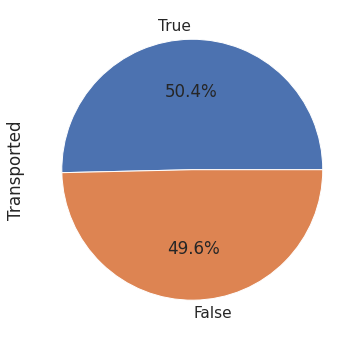

In [7]:
plt.figure(figsize=(6,6))

train['Transported'].value_counts().plot.pie(autopct='%1.1f%%')

Chance is equally likely.

Text(0.5, 0, 'Age (years)')

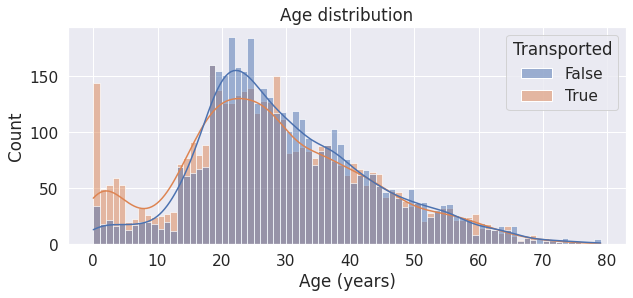

In [8]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

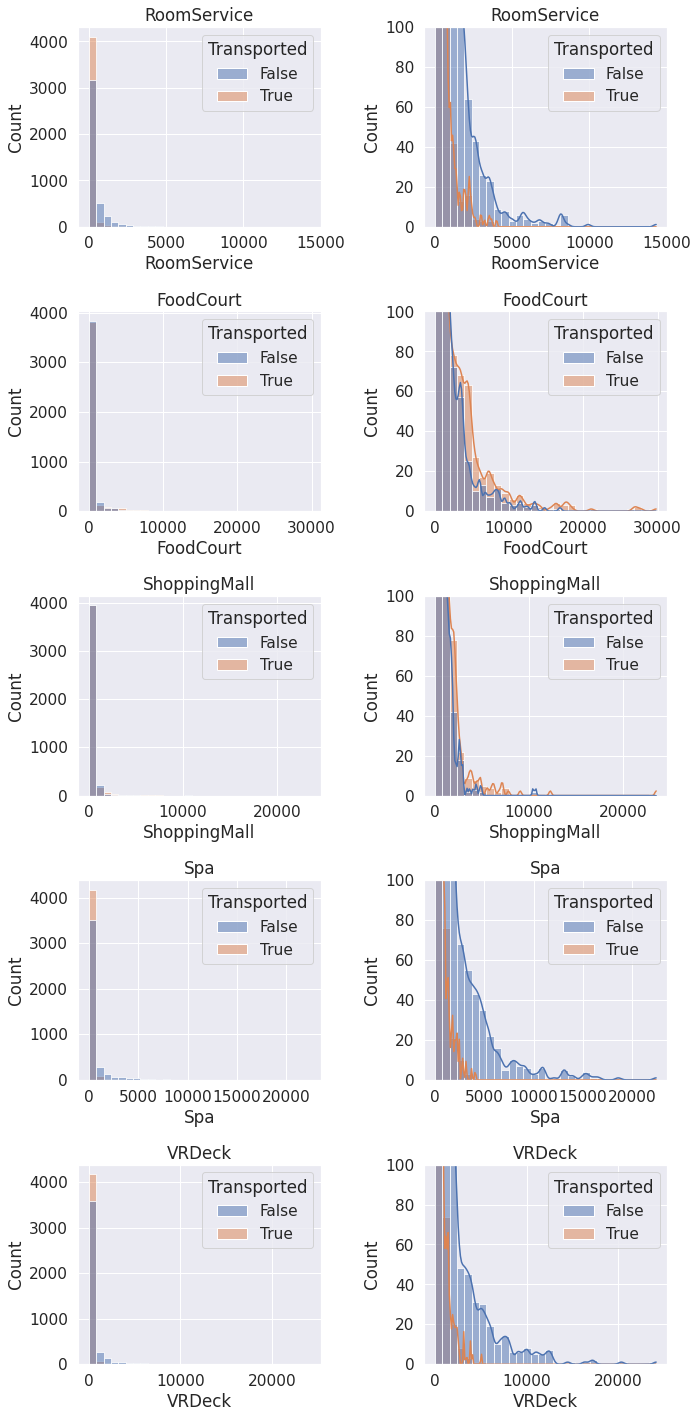

In [9]:
# Expenditure features
exp_features=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot Expenditure Features 
fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(exp_features):
    # Left Plot 
    ax = fig.add_subplot(5, 2, 2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right Plot
    ax = fig.add_subplot(5, 2, 2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

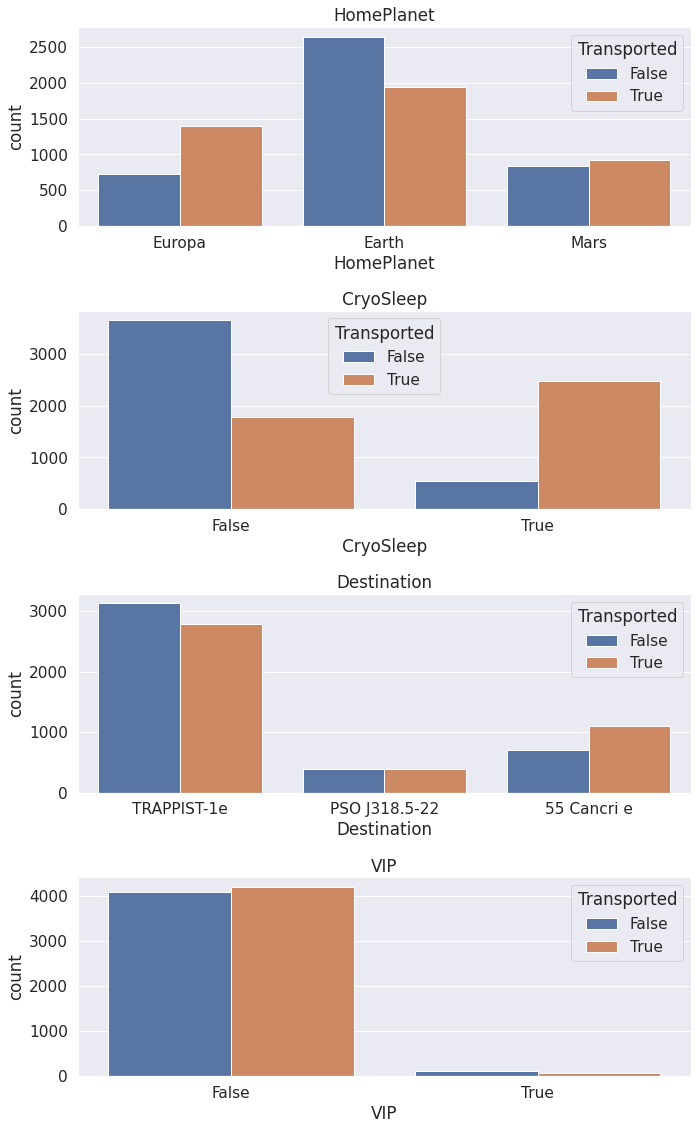

In [10]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

Feature Engineering

Text(0.5, 1.0, 'Age group distribution')

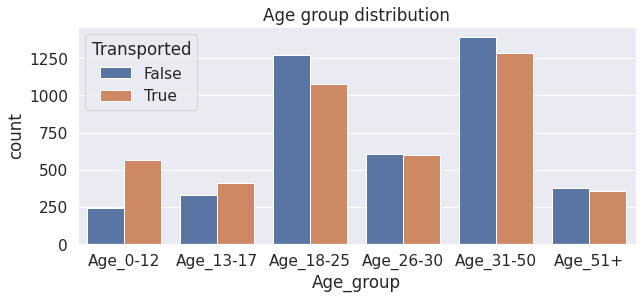

In [11]:
# New features - training set
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# New features - test set
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

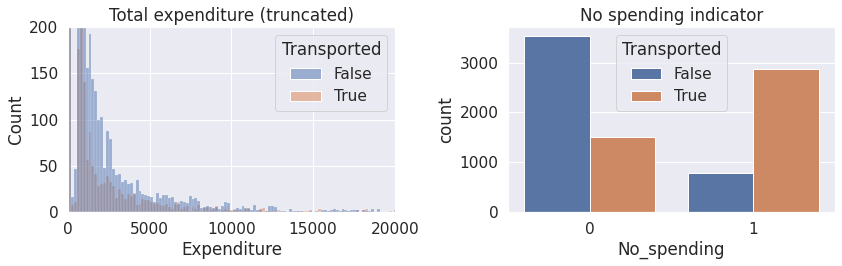

In [12]:
train['Expenditure']=train[exp_features].sum(axis=1)
train['No_spending'] = (train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_features].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)
                                                    
# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

In [13]:
train['PassengerId'].head

<bound method NDFrame.head of 0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object>

In [14]:
train['PassengerId'].head(30)

0     0001_01
1     0002_01
2     0003_01
3     0003_02
4     0004_01
5     0005_01
6     0006_01
7     0006_02
8     0007_01
9     0008_01
10    0008_02
11    0008_03
12    0009_01
13    0010_01
14    0011_01
15    0012_01
16    0014_01
17    0015_01
18    0016_01
19    0017_01
20    0017_02
21    0020_01
22    0020_02
23    0020_03
24    0020_04
25    0020_05
26    0020_06
27    0022_01
28    0024_01
29    0025_01
Name: PassengerId, dtype: object

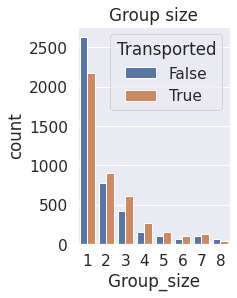

In [15]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

(0.0, 3000.0)

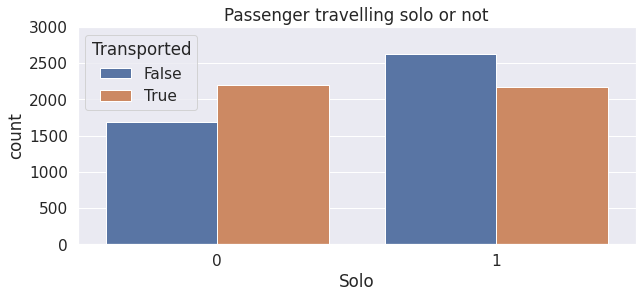

In [16]:
# New feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

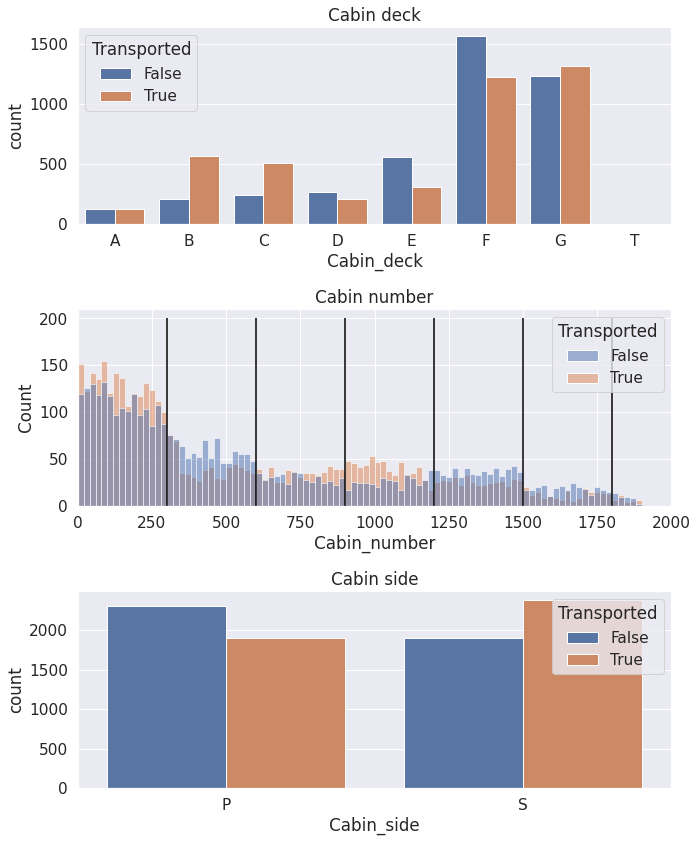

In [17]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

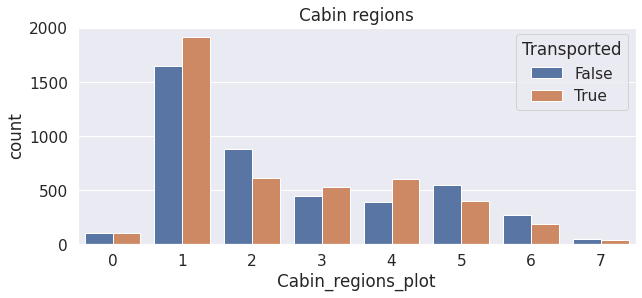

In [18]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True) 

Text(0.5, 1.0, 'Family size')

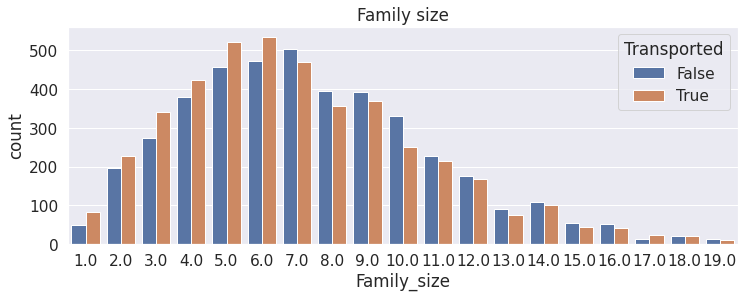

In [19]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

In [20]:
# Labels and features
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test], axis=0).reset_index(drop=True)

In [21]:
# Columns with missing values 
na_cols = data.columns[data.isna().any()].tolist()

# Missing values summary
mv = pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])

In [22]:
mv['Percentage_missing'] = np.round(100 * mv['Number_missing'] / len (data), 2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


Text(0.5, 1.0, 'Heatmap of missing values')

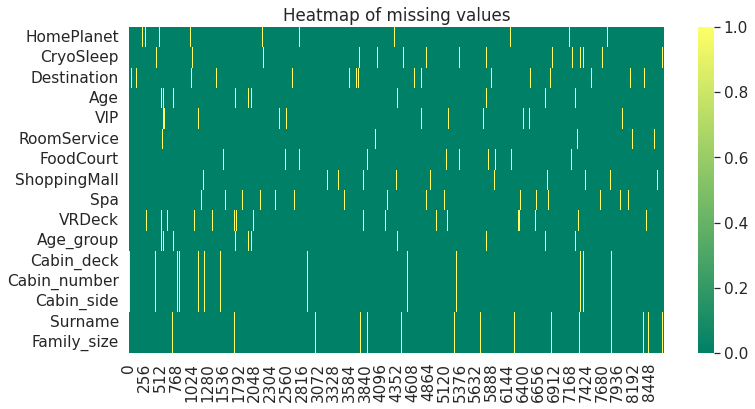

In [23]:
# Heatmap of missing values 
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

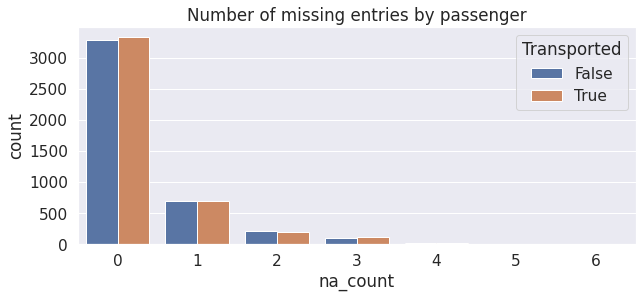

In [24]:
# Countplot of number of missing values by passenger
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis=1, inplace=True)

In [25]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet']).size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


Text(0.5, 1.0, 'Number of unique home planets per group')

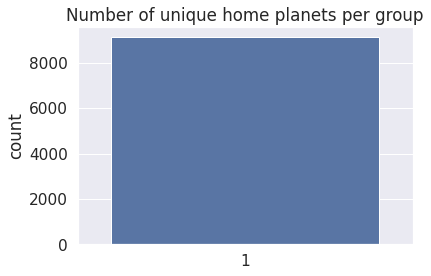

In [26]:
# Countplot of unique values
sns.countplot(x=((GHP_gb>0).sum(axis=1)))
plt.title('Number of unique home planets per group')

In [27]:
# Missing values before
HP_bef = data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]
                                        ['Group'].isin(GHP_gb.index))].index

# Fill corresponding missing values 
data.loc[GHP_index, 'HomePlanet'] = data.iloc[GHP_index, :]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


<AxesSubplot: xlabel='Cabin_deck', ylabel='HomePlanet'>

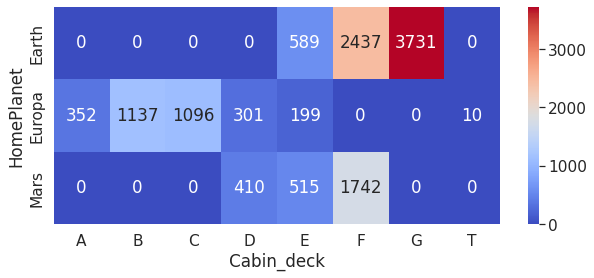

In [28]:
# Joint distribution of CabinDeck and HomePlanet 
CDHP_gb = data.groupby(['Cabin_deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values 
plt.figure(figsize=(10, 4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

Cabin A, B, C guys come from Europa
Cabin G guys come from Earth (Our Planet) !!!
Cabin D, E or F guys come from multiple planets. 

In [29]:
# Missing Values Before 
HP_bef = data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna() & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T']))), 
        'HomePlanet'] = 'Europa'

# Deck G from Earth
data.loc[(data['HomePlanet'].isna() & (data['Cabin_deck'] == 'G')), 'HomePlanet'] = 'Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


HomePlanet and Surname

Text(0.5, 1.0, 'Number of unique planets per surname')

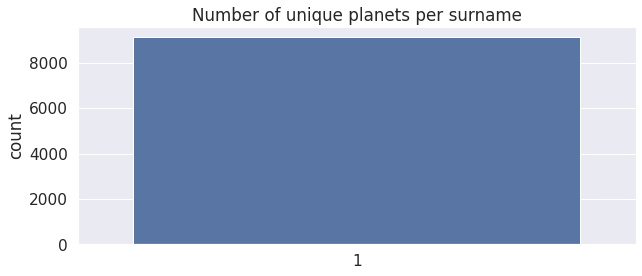

In [30]:
# Joint Distribution of Surname and HomePlanet 
SHP_gb = data.groupby(['Surname', 'HomePlanet']).size().unstack().fillna(0)

# Countplot of unique values 
plt.figure(figsize=(10, 4))
sns.countplot(x=((GHP_gb>0).sum(axis=1)))
plt.title('Number of unique planets per surname')

Everyone with the same surname comes from the same home planet.

In [31]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


In [32]:
# Only 10 HomePlanet missing values left - let's look at them
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


<AxesSubplot: xlabel='HomePlanet', ylabel='Destination'>

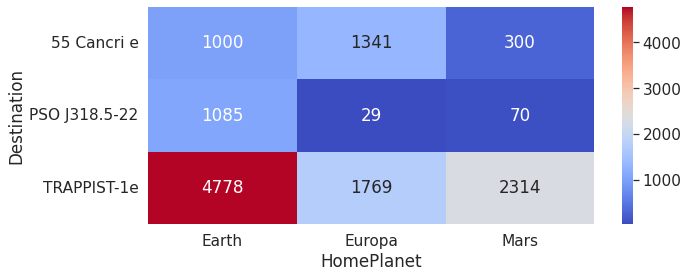

In [33]:
# Joint distribution of HomePlanet and Destination 
HPD_gb = data.groupby(['HomePlanet', 'Destination'])['Destination'].size().unstack().fillna(0)

# HeatMap of missing values
plt.figure(figsize=(10, 4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [34]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


In [35]:
# Missing values before
D_bef=data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


Text(0.5, 1.0, 'Number of unique surnames by group')

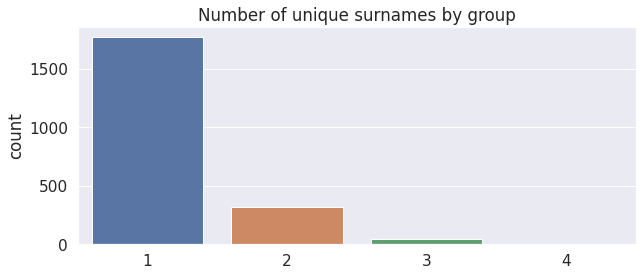

In [36]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)
val = (GSN_gb>0).sum(axis=1)

count1 = ((val == 1).sum()) / val.count()
count1
plt.figure(figsize=(10, 4))
sns.countplot(x = val)
plt.title('Number of unique surnames by group')

Nearly 83% of groups contain 1 family

In [37]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


In [38]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Surname', 'Family_size'],
      dtype='object')

In [39]:
# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family's size feature
data['Family_size'] = data['Surname'].map(lambda x : data['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
data.loc[data['Surname'] == 'Unknown', 'Surname'] = np.nan

# Unknown surname means no family 
data.loc[data['Family_size'] > 100, 'Family_size'] = 0

Cabin size and group

In [40]:
data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep        310
Destination        0
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Age_group        270
Expenditure        0
No_spending        0
Group              0
Group_size         0
Solo               0
Cabin_deck       299
Cabin_number     299
Cabin_side       299
Cabin_region1      0
Cabin_region2      0
Cabin_region3      0
Cabin_region4      0
Cabin_region5      0
Cabin_region6      0
Cabin_region7      0
Surname          155
Family_size        0
dtype: int64

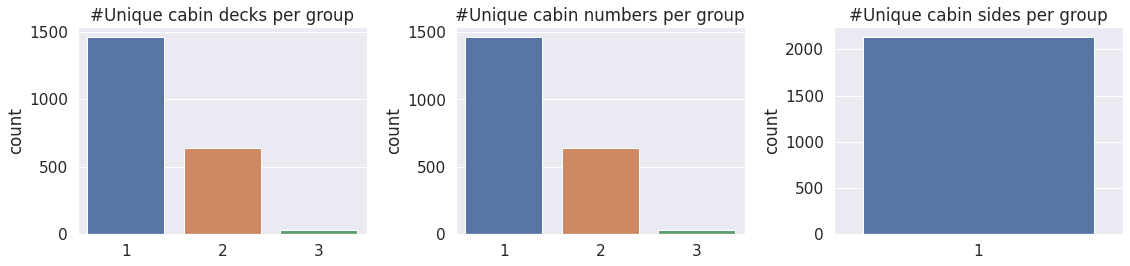

In [41]:
# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

val = (GCD_gb>0).sum(axis=1)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot(x = val)
plt.title('#Unique cabin decks per group')

plt.subplot(1,3,2)
sns.countplot(x=(GCN_gb>0).sum(axis=1))
plt.title('#Unique cabin numbers per group')

plt.subplot(1,3,3)
sns.countplot(x=(GCS_gb>0).sum(axis=1))
plt.title('#Unique cabin sides per group')
fig.tight_layout()

In [42]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


Text(0.5, 1.0, 'Ratio of cabin side by surname')

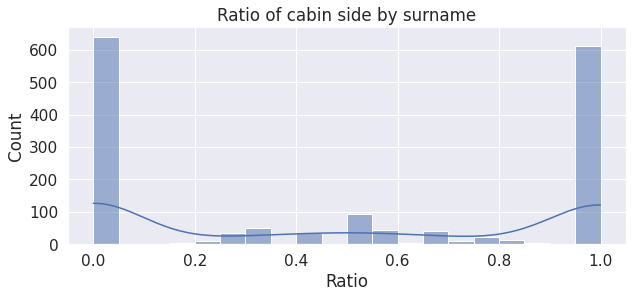

In [56]:
SCS_gb = data[data['Group_size']>1].groupby(['Surname', 'Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio'] = SCS_gb['P'] / (SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')

In [57]:
# Print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 76.7 %


Cabin_side,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


In [58]:
# Missing values before 
CS_bef = data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

# Passengers with missing Cabin side and in a family with known Cabin side 
SCS_index = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname'])
                                            .isin(SCS_gb.index)].index

In [64]:
# Fill corresponding missing values 
data.loc[SCS_index, 'Cabin_side'] = data.iloc[SCS_index, :]['Surname'].map(lambda x :
                                                        SCS_gb.idxmax(axis=1)[x])
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 162
#Cabin_side missing values after: 66


In [65]:
# Value counts
data['Cabin_side'].value_counts()

S    6504
P    6400
Name: Cabin_side, dtype: int64

In [66]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Fill remaining missing values with outlier
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 66
#Cabin_side missing values after: 0


In [67]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


In [73]:
# Joint distribution
data.groupby(['HomePlanet', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0.0,0.0,0.0,0.0,601.0,2496.0,3821.0,0.0
Europa,361.0,1161.0,1122.0,309.0,204.0,0.0,0.0,11.0
Mars,0.0,0.0,0.0,421.0,529.0,1772.0,0.0,0.0


In [74]:
data.groupby(['HomePlanet', 'Solo', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck           A      B      C      D      E       F       G    T
HomePlanet Solo                                                        
Earth      0       0.0    0.0    0.0    0.0  171.0   595.0  1577.0  0.0
           1       0.0    0.0    0.0    0.0  430.0  1901.0  2244.0  0.0
Europa     0     250.0  841.0  752.0  179.0   88.0     0.0     0.0  3.0
           1     111.0  320.0  370.0  130.0  116.0     0.0     0.0  8.0
Mars       0       0.0    0.0    0.0  208.0  243.0   916.0     0.0  0.0
           1       0.0    0.0    0.0  213.0  286.0   856.0     0.0  0.0

In [75]:
data.groupby(['HomePlanet', 'Solo', 'Cabin_deck', 'Destination'])['Cabin_deck'].size().unstack().fillna(0)

Destination                 55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet Solo Cabin_deck                                         
Earth      0    E                  20.0           18.0        133.0
                F                  90.0           67.0        438.0
                G                 272.0          230.0       1075.0
           1    E                  47.0           25.0        358.0
                F                 289.0          262.0       1350.0
                G                 269.0          466.0       1509.0
Europa     0    A                  96.0            2.0        152.0
                B                 377.0            5.0        459.0
                C                 313.0           11.0        428.0
                D                  59.0            0.0        120.0
                E                  35.0            0.0         53.0
                T                   2.0            0.0          1.0
           1    A                  67.0            0.0         44.0
                B                 141.0            0.0        179.0
                C                 159.0           10.0        201.0
                D                  46.0            0.0         84.0
                E                  34.0            0.0         82.0
                T                   0.0            0.0          8.0
Mars       0    D                  32.0            8.0        168.0
                E                  15.0            9.0        219.0
                F                 104.0           14.0        798.0
           1    D                  40.0            9.0        164.0
                E                  16.0            7.0        263.0
                F                  92.0           21.0        743.0

In [76]:
# Missing values befor 
CD_bef = data['Cabin_deck'].isna().sum()

# Fill missing values using the mode 
na_rows_CD = data.loc[data['Cabin_deck'].isna(), 'Cabin_deck'].index 

data.loc[data['Cabin_deck'].isna(), 'Cabin_deck'] = data.groupby(['HomePlanet', 'Destination', 
                                'Solo'])['Cabin_deck'].transform(lambda x : x.fillna(
                                pd.Series.mode(x)[0]))[na_rows_CD]

In [77]:
# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 162
#Cabin_deck missing values after: 0


CabinNumber and CabinDeck

Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

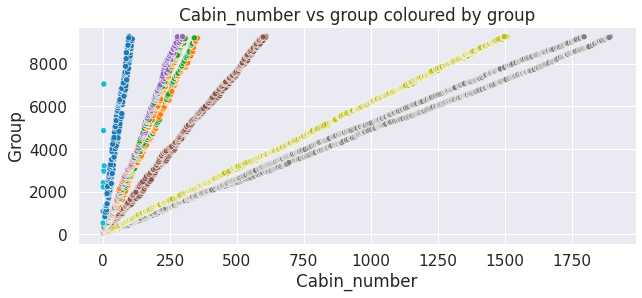

In [78]:
# Scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
plt.title('Cabin_number vs group coloured by group')

In [81]:
# Missing values before
CN_bef = data['Cabin_number'].isna().sum() 

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D','E', 'F', 'G']:
    # Features and Labels 
    X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    
    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # Fill missing values with predictions
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


In [82]:
# One-hot encode cabin regions
data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int) 

In [83]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [84]:
# Missing values before
V_bef=data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP']=False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


Age

In [86]:
# Joint Distribution 
# Joint distribution
data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [88]:
# Missing values before
A_bef=data[exp_features].isna().sum().sum()

# Fill missing values using the median
na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

# Print number of missing values left
print('#Age missing values before:',A_bef)
print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 1410
#Age missing values after: 0


In [89]:
# Update age group feature
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

CyroSleep

In [90]:
# Joint distribution 
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [91]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


In [93]:
print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True,exp_features].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [97]:
# Missing values before
E_bef=data[exp_features].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_features:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_features].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


In [98]:
# Joint distribution
data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [ ]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# Fill remaining missing values using the median 
for col in exp_feats:
    na_rows = data.loc[data[col].isna(), col].index